In [241]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import coint
from scipy.stats import pearsonr, zscore
from arch.unitroot import engle_granger

# Establecer la fuente Helvetica
mpl.rcParams['font.family'] = 'Helvetica'

In [274]:
def filter_signals(dates):
    output = []
    for i in range(len(dates) - 1):
        if (dates[i].month) + 1 != (dates[i+1].month):
            output.append(dates[i])
    output.append(dates[-1])
    return output

In [164]:
def lagged_correlations_computing(df, col1, col2, max_lags):
    correlations = {}
    # Calculate correlation for each lag and store it in the dictionary
    for lag in range(0, max_lags+1):
        serie_1= df[col1].shift(lag).dropna().tolist()
        #serie_1 = zscore(serie_1)
        serie_2 = df[col2].tolist()
        serie_2 = serie_2[lag:]
        #serie_1 = zscore(serie_2)
        correlations[lag] = pearsonr(serie_1,serie_2)[0]
    # Print dictionary of correlations for each lag
    return correlations

#lagged_correlations_computing(df, maturities[3][0],  maturities[3][1], 40)

In [165]:
def dynamicZScore(data, short, long):
    short_mean_df = data.rolling(short).mean()
    long_mean_df = data.rolling(long).mean()
    long_std_df=data.rolling(long).std()
    return (short_mean_df - long_mean_df)/long_std_df

### Retrieving Data

Available data:

- Gouvernment Yields: By maturity
- IG Credit Spread: By maturity, by index
- HY Credit Spread: By Index.


In [183]:
df = pd.read_excel("Project 1 - Data.xlsx", sheet_name="Gov't bond yields", header = 1, usecols="A:J").dropna(how = "all", axis = 1)
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.set_index("Unnamed: 0", inplace = True)
df.index.names = [None]
euro_df = df.iloc[:,:4]
euro_df["Average Yield"] =euro_df.mean(axis=1)
us_df = df.iloc[:,4:]

df_spread = pd.read_excel("Project 1 - Data.xlsx", sheet_name="Spreads, OAS, bp", header = 1, usecols="A:I").dropna(how = "all", axis = 1)
df_spread['Unnamed: 0'] = pd.to_datetime(df_spread['Unnamed: 0'])
df_spread.set_index("Unnamed: 0", inplace = True)
df_spread.index.names = [None]
df = euro_df.merge(df_spread, left_index=True, right_index=True).iloc[::-1]

maturities = {   
3: ['3Y German Bund', '1 - 3 Yrs'],
5: ['5Y German Bund','3 -5 Yrs'],
10:['10Y German Bund', '7 - 10 Yrs'], 
30:['30Y German Bund', '> 10  Yrs']
}
df = df.dropna(axis=1, how='all')
df.head()

/var/folders/mc/sd8lk0kn4fz1q41w5qdn2fhc0000gn/T/ipykernel_93831/43513971.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  euro_df["Average Yield"] =euro_df.mean(axis=1)


,3Y German Bund,5Y German Bund,10Y German Bund,30Y German Bund,Average Yield,Overall investment-grade index,1 - 3 Yrs,3 -5 Yrs,7 - 10 Yrs,> 10 Yrs,HY index
2001-12-31,4.00787,4.50732,5.04130,5.36336,4.729963,122.903330,120.634018,119.529838,132.769688,78.789266,1163.707429
2002-01-31,4.18022,4.58060,4.93347,5.18593,4.720055,116.307681,111.374517,113.909043,120.567631,103.781060,1151.663877
2002-02-28,4.16466,4.59053,4.99218,5.29867,4.761510,127.947711,135.439438,124.252905,121.417109,80.070029,1249.428729
2002-03-29,4.57906,4.93554,5.27027,5.54327,5.082035,115.378176,123.545474,111.689894,113.111865,67.946510,1079.784436
2002-04-30,4.35081,4.75073,5.15630,5.46307,4.930227,131.506935,126.076460,130.704404,134.278325,58.049331,1035.808609


### Plotting Investment Grade Spread vs. Yields:

Same patterns for every maturity. But we see a quantitative relationship that may be interesting to point out. __From 2001 to 2008 spreads and yields are not cointegrated, while from 2008 to 2015 they are.__ This shows a synchronized evolution on the long term between 2008 and 2015. Now we need to find an explanation.

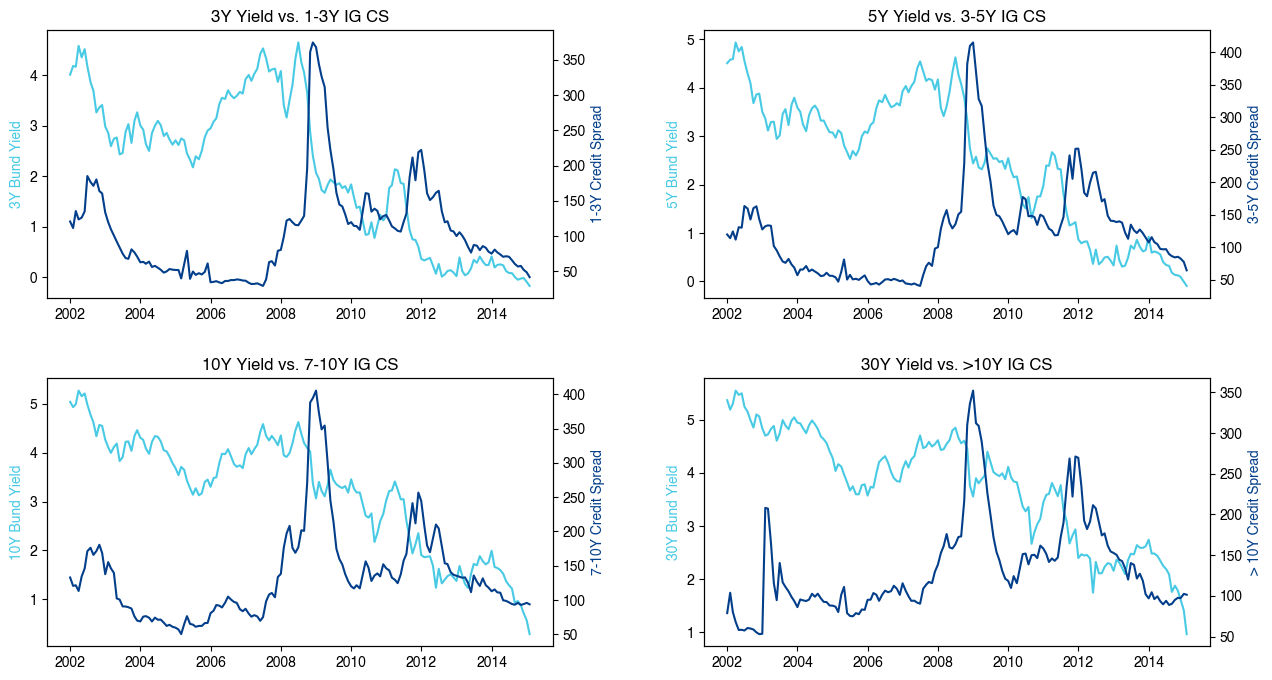

In [184]:
x = df.index
color_yield = '#48cae4'
color_spread = '#023e8a'
# Creamos la figura y los ejes para cada uno de los gráficos
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
(ax1, ax2), (ax3, ax4) = axs

################## GRAPH 1 #####################################
ax1.plot(x, df['3Y German Bund'], color = color_yield)
ax1.set_ylabel('3Y Bund Yield', color = color_yield)
ax1.set_title('3Y Yield vs. 1-3Y IG CS')


ax1b = ax1.twinx()
ax1b.plot(x, df['1 - 3 Yrs'], color = color_spread)
ax1b.set_ylabel('1-3Y Credit Spread', color=color_spread)
ax1b.tick_params(axis='y')

################## GRAPH 2 #####################################
ax2.plot(x, df['5Y German Bund'], color = color_yield)
ax2.set_ylabel('5Y Bund Yield', color = color_yield)
ax2.set_title('5Y Yield vs. 3-5Y IG CS')

ax2b = ax2.twinx()
ax2b.plot(x, df['3 -5 Yrs'], color = color_spread)
ax2b.set_ylabel('3-5Y Credit Spread', color=color_spread)
ax2b.tick_params(axis='y')

################## GRAPH 3 #####################################
ax3.plot(x, df['10Y German Bund'], color = color_yield)
ax3.set_ylabel('10Y Bund Yield', color = color_yield)
ax3.set_title('10Y Yield vs. 7-10Y IG CS')

ax3b = ax3.twinx()
ax3b.plot(x, df['7 - 10 Yrs'], color = color_spread)
ax3b.set_ylabel('7-10Y Credit Spread', color=color_spread)
ax3b.tick_params(axis='y')

################## GRAPH 4 #####################################
ax4.plot(x, df['30Y German Bund'], color = color_yield)
ax4.set_ylabel('30Y Bund Yield', color = color_yield)
ax4.set_title('30Y Yield vs. >10Y IG CS')

ax4b = ax4.twinx()
ax4b.plot(x, df['> 10  Yrs'], color = color_spread)
ax4b.set_ylabel('> 10Y Credit Spread', color = color_spread)
ax4b.tick_params(axis='y')

# Ajustamos los espacios entre los gráficos para que no se superpongan
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('Yield vs. CS comparison.png')
# Mostramos el plot
plt.show()

In [185]:
mask = (df.index >= '2007-06-06') & (df.index <= '2020-12-31')
short_df = df[maturities[3]].apply(zscore)
#short_df[maturities[3][0]] = dynamicZScore(df[maturities[3][0]], 6, 12).shift(36)
#short_df[maturities[3][1]] = dynamicZScore(df[maturities[3][1]], 6, 12)
short_df = df[mask]
eg_test = engle_granger(short_df[maturities[3][0]], short_df[maturities[3][1]], trend = "n")
eg_test


Test Statistic,-3.129
P-value,0.019
ADF Lag length,3
Estimated Root ρ (γ+1),0.912


<AxesSubplot:>

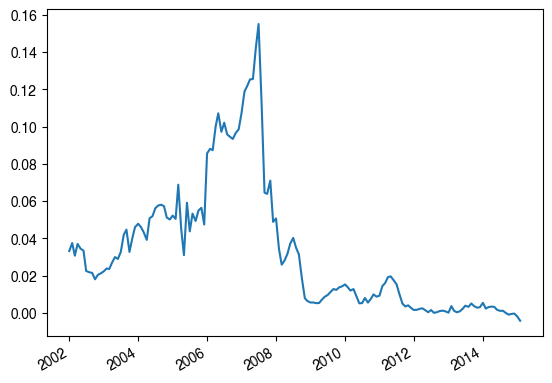

In [187]:
color_yield = '#48cae4'
(df[maturities[3][0]]/df[maturities[3][1]]).plot()

#### 2001 - 2008: 


The low corporate credit spreads in Europe between 2002 and 2008 can be attributed to a number of factors. First, there was a general trend towards declining credit risk during this period, as companies enjoyed increased profitability and financial stability in the wake of the dot-com bubble. Second, the European Central Bank's accommodative monetary policy helped to keep borrowing costs low, encouraging firms to take on debt and invest in growth opportunities. Third, the introduction of the euro in 2002 brought greater integration and stability to European financial markets, reducing the risk of currency fluctuations and boosting investor confidence. Finally, the securitization of debt allowed banks to offload risk and improve their balance sheets, leading to greater liquidity and lower funding costs for borrowers. All of these factors contributed to the low credit spreads observed in the European corporate bond market during this period.

### Studying IG-HY spread vs Government Yields

Here we see a much higher correlation: around 40% for a 7 months lag on the average yield. Graphs shows us that yield (8M lag) and HY vs. IG Spread evolve together.

- Correlation: 40%
- Cointegration: Yes (p-value: 4.7%)

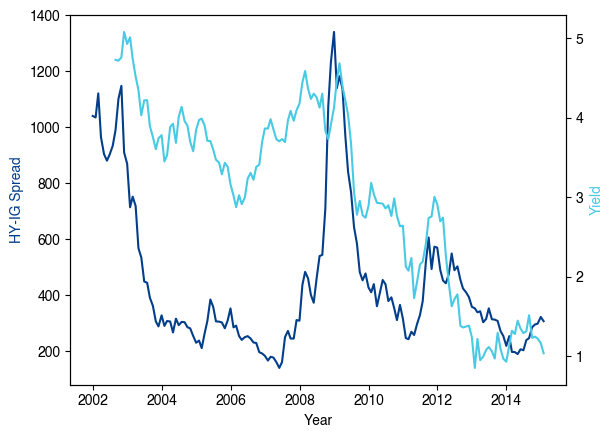

<Figure size 640x480 with 0 Axes>

In [189]:
df["HY - IG Spread"] = df["HY index"] - df["Overall investment-grade index"]
color_yield = '#48cae4'
color_spread = '#023e8a'
fig, ax1 = plt.subplots()
# Plot the Sales column on primary y-axis
ax1.plot(df.index, df['HY - IG Spread'], color=color_spread)
ax1.set_xlabel('Year')
ax1.set_ylabel('HY-IG Spread', color = color_spread)

# Create a secondary y-axis object
ax2 = ax1.twinx()

# Plot the Profit column on secondary y-axis
ax2.plot(df.index, df['Average Yield'].shift(8), color=color_yield)
ax2.set_ylabel('Yield', color=color_yield)

# Show the plot
plt.show()
plt.savefig("Credit_Spread_and_lagged_8M_Yield.png")

In [190]:
eg_test = engle_granger(df["HY - IG Spread"][8:], df['Average Yield'].shift(8)[8:], trend = "n")
eg_test

Test Statistic,-2.750
P-value,0.052
ADF Lag length,1
Estimated Root ρ (γ+1),0.932


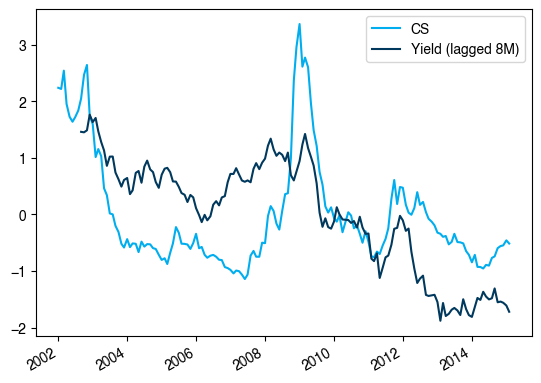

In [191]:
df_zscore = pd.DataFrame(index = df.index.tolist())
color_spread = "#00aeef"
color_yield = "#00395d"
df_zscore["Yield (lagged 8M)"] = zscore(df['Average Yield'].shift(8).dropna())
df_zscore["CS"] = zscore(df["HY - IG Spread"].dropna())
df_zscore.plot(y=['CS', 'Yield (lagged 8M)'], color=[color_spread, color_yield])
plt.savefig("ZScore.png")

### Absolute Dynamic ZScore

Here we simply look at the dynamic Z-Score and based on its value we enter or exit.

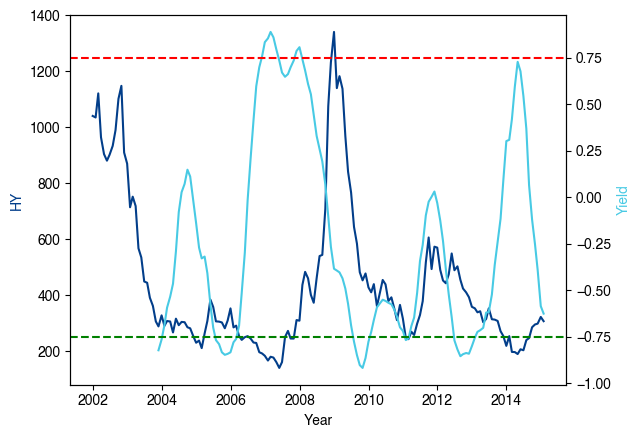

In [265]:
color_yield = '#48cae4'
color_spread = '#023e8a'
fig, ax1 = plt.subplots()
# Plot the Sales column on primary y-axis
ax1.plot(df.index, df["HY - IG Spread"], color=color_spread)
ax1.set_xlabel('Year')
ax1.set_ylabel('HY', color = color_spread)

# Create a secondary y-axis object
ax2 = ax1.twinx()

# Plot the Profit column on secondary y-axis
ax2.plot(df.index, dynamicZScore(df['Average Yield'], 12, 24), color=color_yield)
ax2.set_ylabel('Yield', color=color_yield)
ax2.axhline(y=-0.75, color='green', linestyle='--')
ax2.axhline(y=0.75, color='red', linestyle='--')

# Show the plot
plt.show()

In [291]:
mask_buy = dynamicZScore(df['Average Yield'], 12, 24)< -0.75
mask_sell = dynamicZScore(df['Average Yield'], 12, 24)> 0.75
buy_signal_date = df[mask_buy].index.tolist()
sell_signal_date = df[mask_sell].index.tolist()
total_dates = df.index.tolist()

buy_dates = []
sell_dates = []
for i, valor in enumerate(total_dates):
    if valor in buy_signal_date:
        index = buy_signal_date.index(valor)
        if i + 9 < len(total_dates):
            buy_dates.append(total_dates[i + 9])
    elif valor in sell_signal_date:
        index = sell_signal_date.index(valor)
        if i + 9 < len(total_dates):
            sell_dates.append(total_dates[i + 9])
#df.loc[buy_dates, 'HY index']
buy_dates = filter_signals(buy_dates) 
sell_dates = filter_signals(sell_dates)
sell_signal_date = filter_signals(sell_signal_date)
buy_signal_date = filter_signals(buy_signal_date)

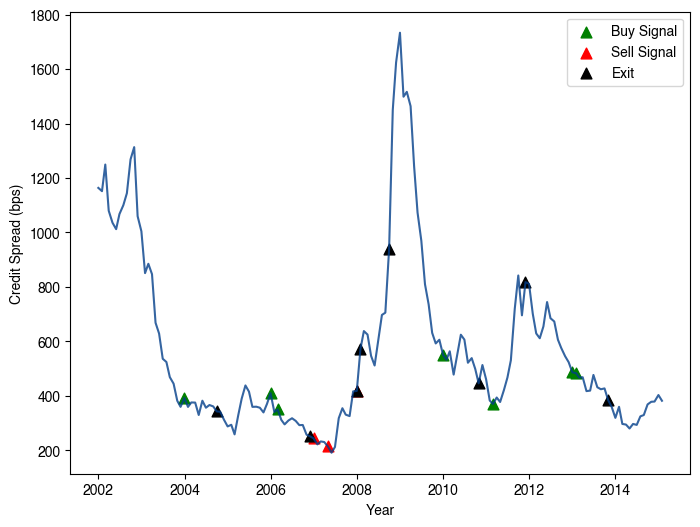

<Figure size 640x480 with 0 Axes>

In [292]:
import matplotlib.pyplot as plt


# Crea la figura y los tres gráficos
fig, ax = plt.subplots(figsize=(8, 6))

# Grafico de la línea
ax.plot(df.index, df['HY index'].values, color =  '#023e8a', alpha = 0.8)

# Grafico de los puntos aislados
ax.scatter(buy_signal_date, df.loc[buy_signal_date, 'HY index'].values, label='Buy Signal', marker='^', s = 60, color='green')
ax.scatter(sell_signal_date, df.loc[sell_signal_date, 'HY index'].values, label='Sell Signal',marker='^', s = 60, color='red')
ax.scatter(buy_dates, df.loc[buy_dates, 'HY index'].values, label='Exit', marker='^',s = 60, color='black')
ax.scatter(sell_dates, df.loc[sell_dates, 'HY index'].values, marker='^',s = 60, color='black')
# Configuración de la leyenda
ax.legend()

# Configuración del título y los ejes
ax.set_xlabel('Year')
ax.set_ylabel('Credit Spread (bps)')

# Mostrar el gráfico
plt.show()
plt.savefig("Trading Strategy.png")

### Relative Dynamic ZScore

Now let's base it on the difference in Z-Score from one era to another.